In [33]:
# Preparations
from PIL import Image
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import scipy
from itertools import compress

from scipy.ndimage import maximum_filter
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import convolve1d as conv1
from scipy.ndimage.filters import convolve as conv2
from scipy.misc import imresize, imsave

from skimage.transform import resize, rotate, SimilarityTransform
from skimage.io import imread
from skimage.measure import ransac

from utils import plotFrame, plotFrameBoth, plotImBoth, findNeighbours, plotMatches, geometricVerification

import time

In [ ]:
# Description:
#    Exercise7 VGG practical notebook (stage1, fast track).
#
# This software is inspired by original object instance recognition
# VGG practical. 
# Licence; please refer to the file 
# Licence.txt, included with the software, for details.

# CS-E4850 Computer Vision Exercise Round 7

This is a minimal python version of Oxford Visual Geometry Group's Matlab$^{\texttt{TM}}$ practical on recognition of object instances (see the original webpage <a href= http://www.robots.ox.ac.uk/~vgg/practicals/instance-recognition/index.html#part3>here</a>). By "minimal" it is meant that it uses pre-computed SIFT features and some other needed resources. All of them are calculated using the freely available matlab scripts found in the practical's github <a href=https://github.com/vedaldi/practical-object-instance-recognition >repository</a>. The practical is largely based on the vlfeat library (cf. http://www.vlfeat.org/) which unfortunately does not have a Python interface. 
<br><br> 
This notebook is <b>the first part (PART I)</b> of the practical on the so-called  <em> <b><font color="red">fast track</font></b> </em> and is about <b>sparse features for matching object instances</b>.
<br><br>
Go through the notebook and answer the questions given in the practical's webpage. You can write your answers to a separate text document and submit that instead of the filled notebook as you are not supposed to implement anything in this exercise.

## Stage I.A: SIFT features detector
As you may already know, the SIFT feature has basically two modes of operation called as the detector and the descriptor. Go now to the practical's <a href=http://www.robots.ox.ac.uk/~vgg/practicals/instance-recognition/index.html#stage-ib-sift-features-descriptors-and-matching-between-images>webpage</a> and continue reading what is written there. After that, answer the two questions of Stage I.A.

NOTE#1: Magnifying glass tool not implemented in this Python version.<br>
NOTE#2: As we are using precomputed SIFT features you can skip the task related to increasing the 'peakThreshold'.
<br>

Type your answers here (there are two questions):


In [1]:
def getFeatures(imname, postfix=""):
    data = np.load('./data_part1/{}_sift_disc_kps_descrs{}.npy'.format(imname,postfix), encoding='latin1')
    kps = data.item().get('keypoints')
    descrs = data.item().get('descriptors')
    kps = kps.T
    descrs = descrs.T
    return kps, descrs

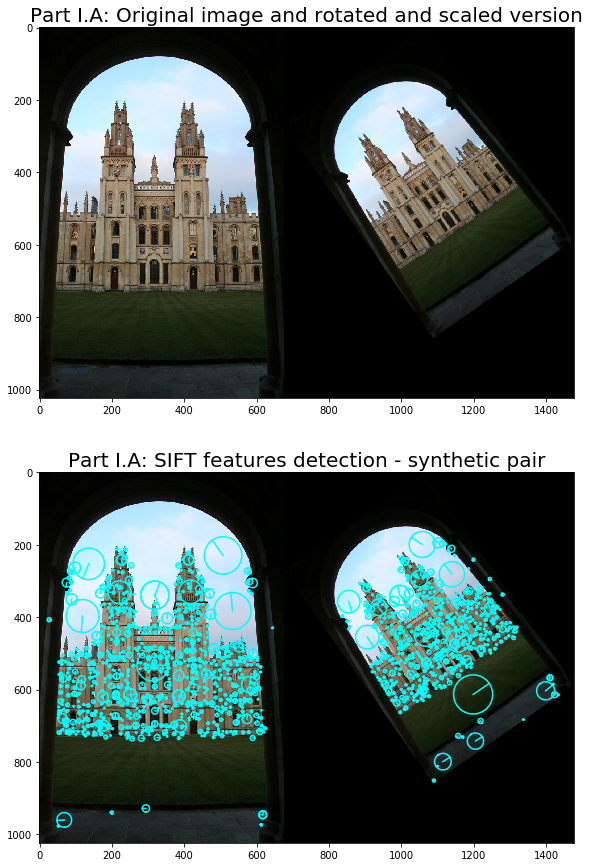

In [35]:
## -------------------------------------------------------------------
#                                   Stage I.A: SIFT features detection
# --------------------------------------------------------------------

# Load an image
im1 = imread('data/oxbuild_lite/all_souls_000002.jpg') / 255.

# Let the second image be a rotated and scaled version of the first
im3_ = rotate(im1, 35, 'bilinear')
im3_shape = np.round((0.7 * im3_.shape[0], 0.7 * im3_.shape[1]))
im3 = resize(im3_, im3_shape)

# Display images
im3new = np.vstack((im3,np.zeros((im1.shape[0]-im3.shape[0],im3.shape[1],3))))
imboth = np.hstack((im1,im3new))

# Compute SIFT features for each (precomputed) 
# In our precomputed features the 'peakThreshold' param is set to 0.01 
# like in the original matlab version
kps1, descrs1 = getFeatures('im1')
kps3, descrs3 = getFeatures('im3rotscaled')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,15))
ax = axes.ravel()
ax[0].set_title("Part I.A: Original image and rotated and scaled version", fontsize=20)
plotImBoth(ax[0], im1, im3)
ax[1].set_title("Part I.A: SIFT features detection - synthetic pair", fontsize=20)
plotFrameBoth(ax[1], im1, im3, kps1, kps3, [])
plt.show()

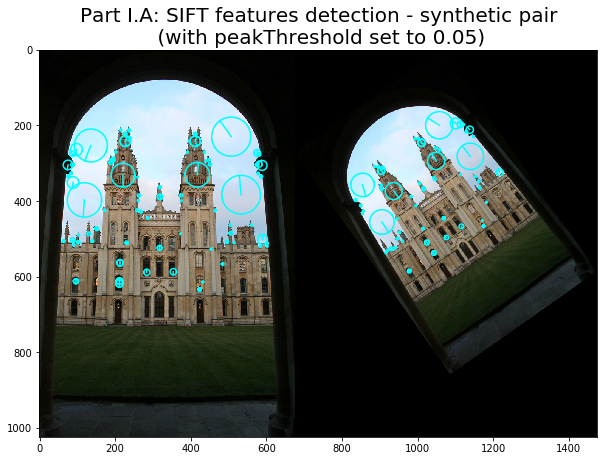

In [36]:
# Compute SIFT features for each (precomputed), set peakThreshold as 0.05
kps1_, descrs1_ = getFeatures('im1','_0_05')
kps3_, descrs3_ = getFeatures('im3rotscaled', '_0_05')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
ax.set_title("Part I.A: SIFT features detection - synthetic pair\n (with peakThreshold set to 0.05)", fontsize=20)
plotFrameBoth(ax, im1, im3, kps1_, kps3_, [])
plt.show()

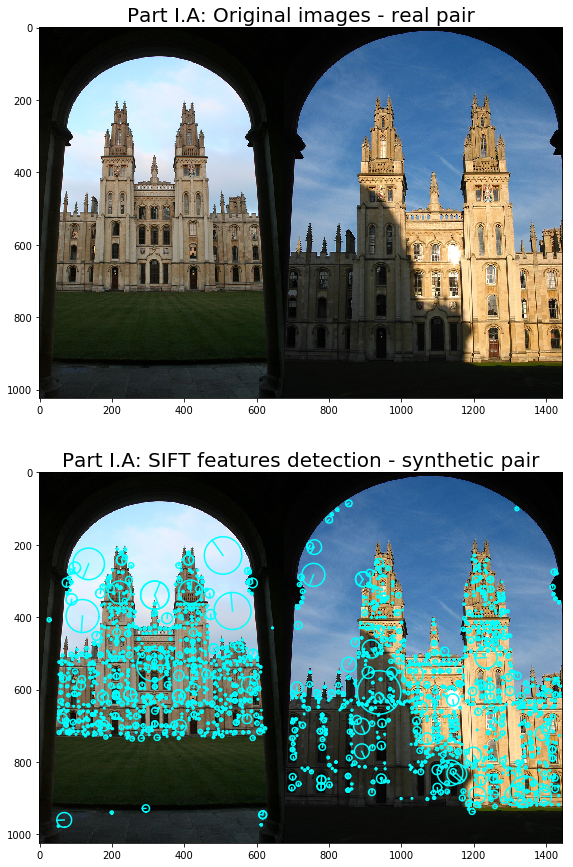

In [37]:
# Load the second image of the same scene
im2 = imread('data/oxbuild_lite/all_souls_000015.jpg') / 255.

# Compute SIFT features for each (precomputed)
# peakThreshold was 0.01
kps2, descrs2 = getFeatures('im2')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,15))
ax = axes.ravel()
ax[0].set_title("Part I.A: Original images - real pair", fontsize=20)
plotImBoth(ax[0], im1, im2)
ax[1].set_title("Part I.A: SIFT features detection - synthetic pair", fontsize=20)
plotFrameBoth(ax[1], im1, im2, kps1, kps2, [])
plt.show()

## Stage I.B: SIFT features detectors and matching between images
At this stage, we will start using the descriptors ('descrs*') computed over each detection to match the detections between the image pairs. Continue reading the <a href= http://www.robots.ox.ac.uk/~vgg/practicals/instance-recognition/index.html#stage-ib-sift-features-descriptors-and-matching-between-images>practical</a> at Stage I.B and answer the qestions.<br><br>
Type your answers here (there are two questions):

HINT: For the first question see the two largest rectangles.

In [38]:
def getDescriptorFramesAndKeypoints():
    data = np.load('./data_part1/im1_sift_descriptor_xyall_every50th.npy', encoding='latin1')
    xall = data.item().get('xall')
    yall = data.item().get('yall')

    data = np.load('./data_part1/im1_sift_disc_kps_every50th.npy', encoding='latin1')
    kps = data.item().get('keypoints')
    kps = kps.T
    return xall, yall, kps

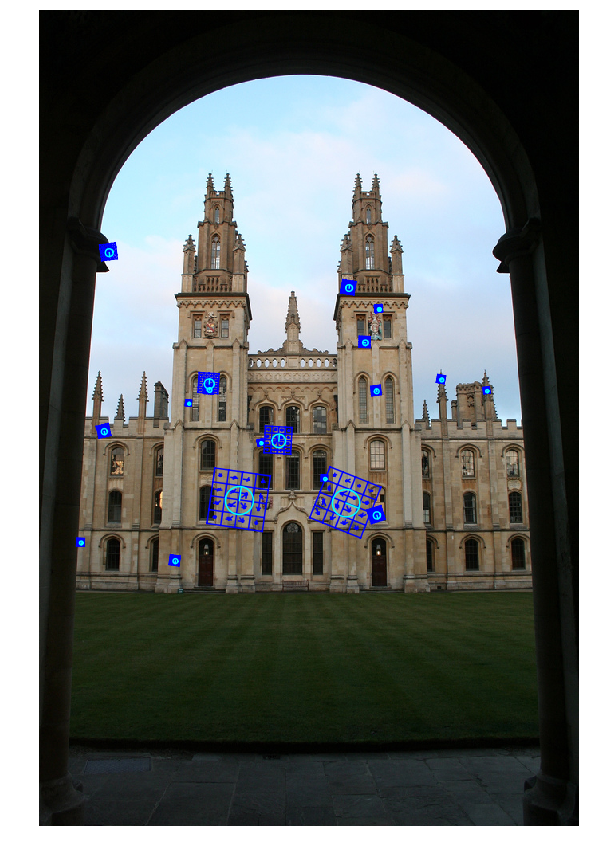

In [39]:
# Visualize SIFT descriptors (only a few)
xall, yall, kps = getDescriptorFramesAndKeypoints()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
# Plot the SIFT descriptor (precomputed) regions of interest for the detected feature frames
ax.plot(xall, yall, color='b')
# Overlay the corresponding frames
plotFrame(ax, im1, kps)
plt.show()

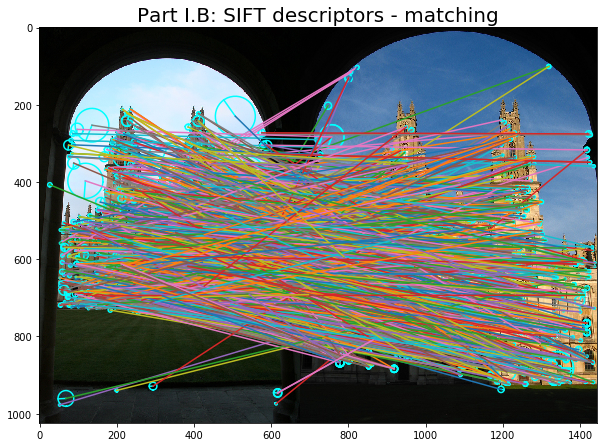

In [40]:
# Compute SIFT features for each (precomputed)
kps2, descrs2 = getFeatures('im2')

# Find for each descriptor in im1 the closest descriptor in im2
# have a look at the findNeighbours in utils.py
ind, dist = findNeighbours(descrs1, descrs2, 1)

matches_raw = np.vstack((np.arange(descrs1.shape[0]), ind))
matches_raw = matches_raw.T

# Display correspondences
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
plotFrameBoth(ax, im1, im2, kps1, kps2, matches_raw, plotMatches=True)
ax.set_title("Part I.B: SIFT descriptors - matching", fontsize=20)
plt.show()

In [26]:
# Some guidance to the second question ...
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
#plotFrameBoth(ax, im1, im2, kps1, kps2, matches_raw[::20,:], plotMatches=True)
#ax.set_title("Part I.B: SIFT descriptors - matching", fontsize=20)
#plt.show()

## Stage I.C: Improving SIFT matching using Lowe’s second nearest neighbour test
Lowe introduced a very nice idea to polish the raw matches...continue reading <a href= http://www.robots.ox.ac.uk/~vgg/practicals/instance-recognition/index.html#stage-ib-sift-features-descriptors-and-matching-between-images>here</a> at Stage I.C to see what he introduced and answer the question.

Type your answer here (there is only one question):

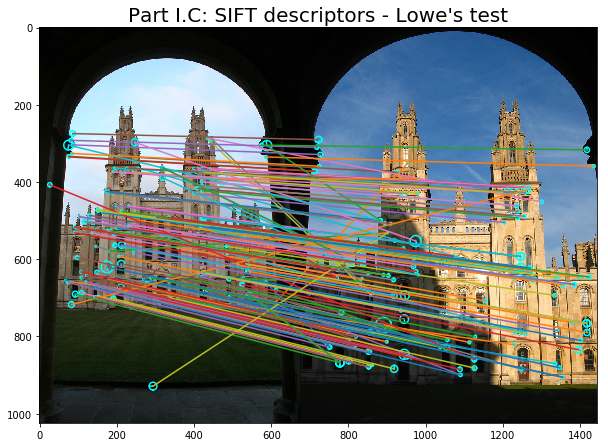

In [41]:
## -------------------------------------------------------------------
#   Stage I.C: Better matching w/ Lowe's second nearest neighbour test
# --------------------------------------------------------------------

# Find the top two neighbours as well as their distances
ind, dist = findNeighbours(descrs1, descrs2, 2)

# Accept neighbours if their second best match is sufficiently far off
nnThreshold = 0.8
ratio2 = np.divide(dist[:,0], dist[:,1])
ok = ratio2 <= nnThreshold ** 2

# Construct a list of filtered matches
matches_2nn = np.vstack((np.nonzero(ok), ind[ok, 0]))
matches_2nn = matches_2nn.T

# Display the corresponding matches
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
plotFrameBoth(ax, im1, im2, kps1, kps2, matches_2nn, plotMatches=True)
ax.set_title("Part I.C: SIFT descriptors - Lowe's test", fontsize=20)
plt.show()

## Stage I.D: Improving SIFT matching using a geometric transformation
Finalize by reading the final notes (Stage I.D) of the first part of the <a href= http://www.robots.ox.ac.uk/~vgg/practicals/instance-recognition/index.html#stage-ib-sift-features-descriptors-and-matching-between-images>practical</a>  and do what is asked.

NOTE: Interactive visualisation has not been implemented in this minimal Python version. 

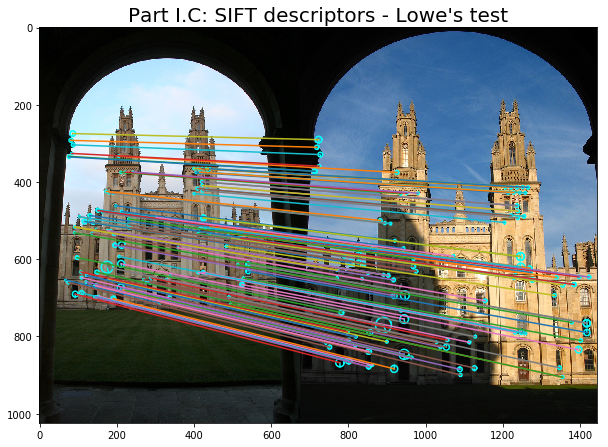

In [42]:
# Geometric verification
inliers, H = geometricVerification(kps1, kps2, matches_2nn, 8)
matches_geom = matches_2nn[inliers,:]

# Display the matches
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
plotFrameBoth(ax, im1, im2, kps1, kps2, matches_geom, plotMatches=True)
ax.set_title("Part I.C: SIFT descriptors - Lowe's test", fontsize=20)
plt.show()